# Multi-batch integration - SKNSH & NBLW


In this notebook, an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile.

This follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), but instead of fine-tuning the entire model, a smaller neural network is trained, using the embeddings of the gene expressions as inputs, to make a prediction.

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

In [1]:
#!pip3 install helical
#!conda install -c conda-forge louvain
#!pip3 install datasets --upgrade

In [2]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt import scGPT, scGPTConfig
from helical.models.geneformer import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import scanpy as sc

  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0 available.


Load target datasets

In [3]:
# Load SKNSH data
adata_sknsh = sc.read_h5ad("210824_aumc00012sc_10k_scRNAseq.h5ad")
# Load NBLW data
adata_nblw = sc.read_h5ad("210824_aumc00013sc_10k_scRNAseq.h5ad")


In [4]:
# Seurat to AnnData conversion can be tricky. Ensure that the raw counts are properly assigned. 
print(adata_sknsh.X)
print(adata_sknsh.raw.X)

  (0, 21)	1.2734390177529604
  (0, 27)	0.6193426585042047
  (0, 39)	0.6193426585042047
  (0, 40)	0.6193426585042047
  (0, 43)	1.488586016192754
  (0, 51)	0.6193426585042047
  (0, 53)	1.488586016192754
  (0, 63)	0.6193426585042047
  (0, 66)	1.488586016192754
  (0, 68)	0.6193426585042047
  (0, 78)	1.488586016192754
  (0, 86)	0.6193426585042047
  (0, 89)	1.488586016192754
  (0, 93)	0.6193426585042047
  (0, 98)	0.6193426585042047
  (0, 122)	0.9989440544059085
  (0, 132)	1.2734390177529604
  (0, 154)	2.8504997381600052
  (0, 157)	0.6193426585042047
  (0, 161)	0.9989440544059085
  (0, 172)	0.6193426585042047
  (0, 178)	0.9989440544059085
  (0, 185)	0.6193426585042047
  (0, 189)	0.6193426585042047
  (0, 190)	1.488586016192754
  :	:
  (2773, 33269)	0.857014536025776
  (2773, 33279)	0.857014536025776
  (2773, 33297)	1.3116333579771218
  (2773, 33304)	1.3116333579771218
  (2773, 33321)	0.857014536025776
  (2773, 33380)	0.857014536025776
  (2773, 33396)	0.857014536025776
  (2773, 33443)	1.3116333

In [5]:
# Seurat to AnnData conversion can be tricky. Ensure that the raw counts are properly assigned. 
print(adata_nblw.X)
print(adata_nblw.raw.X)

  (0, 26)	1.0747923416924812
  (0, 40)	1.0747923416924812
  (0, 53)	1.0747923416924812
  (0, 68)	1.0747923416924812
  (0, 93)	1.0747923416924812
  (0, 154)	3.101138128720335
  (0, 157)	1.0747923416924812
  (0, 178)	1.5807851244880966
  (0, 190)	1.0747923416924812
  (0, 201)	1.9151789721909183
  (0, 214)	1.0747923416924812
  (0, 229)	1.0747923416924812
  (0, 244)	1.9151789721909183
  (0, 259)	1.0747923416924812
  (0, 269)	1.0747923416924812
  (0, 412)	1.9151789721909183
  (0, 445)	1.0747923416924812
  (0, 465)	1.5807851244880966
  (0, 477)	1.0747923416924812
  (0, 483)	1.0747923416924812
  (0, 493)	3.6785182246532266
  (0, 503)	1.0747923416924812
  (0, 526)	1.0747923416924812
  (0, 546)	1.9151789721909183
  (0, 555)	1.0747923416924812
  :	:
  (2304, 33157)	1.0662265400183246
  (2304, 33158)	1.0662265400183246
  (2304, 33207)	1.0662265400183246
  (2304, 33209)	1.0662265400183246
  (2304, 33249)	1.9040753629944949
  (2304, 33297)	2.5198228371001417
  (2304, 33321)	1.5704472242418266
  (23

In [6]:
# Copy raw counts to adata.X if necessary
adata_sknsh.X = adata_sknsh.raw.X.copy()
adata_sknsh.var["gene_name"] = adata_sknsh.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

In [7]:
# Copy raw counts to adata.X if necessary
adata_nblw.X = adata_nblw.raw.X.copy()
adata_nblw.var["gene_name"] = adata_nblw.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

We are interested in the names of the cells we want to predict. They are saved in `adata.obs["active_ident_celltypes"]`.

Additionally, we need to know how many distinct cell types/classes we have.

In [11]:
adata_sknsh.obs


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident
-12sc_AAACCCAAGAAGCGAA-1,0,11659.0,3637,8.808646,-0.276652,-0.410803,G1,0
-12sc_AAACCCAAGGTAATCA-1,0,22215.0,5051,6.356066,-0.134987,-0.163768,G1,0
-12sc_AAACCCAAGTTACGAA-1,0,6705.0,2533,12.125280,-0.221783,-0.268079,G1,0
-12sc_AAACGAAAGAACTTCC-1,0,14121.0,3723,11.429785,-0.299384,-0.395987,G1,0
-12sc_AAACGCTAGTAAGCAT-1,0,22095.0,4660,8.182847,-0.349828,-0.396763,G1,0
...,...,...,...,...,...,...,...,...
-12sc_TTTGGTTAGTTGTCAC-1,0,15085.0,4187,11.753397,-0.026960,0.426062,G2M,0
-12sc_TTTGTTGAGGGATCAC-1,0,8272.0,2817,14.047389,0.155354,0.065814,S,0
-12sc_TTTGTTGCACGAGAAC-1,0,5634.0,2057,13.223287,-0.302874,-0.341721,G1,0
-12sc_TTTGTTGCACTCAGAT-1,0,6006.0,2154,13.569764,-0.346256,-0.293528,G1,0


In [12]:
adata_sknsh.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,gene_name
MIR1302-2HG,0.000000,0.000000,0.000000,0.000000,0,MIR1302-2HG
FAM138A,0.000000,0.000000,0.000000,0.000000,0,FAM138A
OR4F5,0.000000,0.000000,0.000000,0.000000,0,OR4F5
AL627309.1,0.002884,0.002877,0.002940,0.978514,0,AL627309.1
AL627309.3,0.000000,0.000000,0.000000,0.000000,0,AL627309.3
...,...,...,...,...,...,...
AC233755.2,0.000000,0.000000,0.000000,0.000000,0,AC233755.2
AC233755.1,0.000000,0.000000,0.000000,0.000000,0,AC233755.1
AC240274.1,0.251622,0.277089,0.291116,0.951815,0,AC240274.1
AC213203.1,0.000000,0.000000,0.000000,0.000000,0,AC213203.1


Use the Helical package to get the embeddings of the gene expression profile.

The only thing we need to specify is the column containing the names of the genes. (`gene_name` in this case)

The resulting embeddings are the input features `x`.

# scGPT

In [13]:
# TODO: Print progress of the function

def scgpt_get_embeddings(adata, Normalize_SubsetHighlyVariable=False):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Configure and initialize the scGPT model
    scgpt_config = scGPTConfig(batch_size=50, device=device)
    scgpt = scGPT(configurer = scgpt_config)

    # Process the data for the scGPT model
    if Normalize_SubsetHighlyVariable:
        data_processed = scgpt.process_data(adata, gene_names = "gene_name", fine_tuning=True)
    else:
        data_processed = scgpt.process_data(adata, gene_names = "gene_name")

    # Get embeddings
    x_scgpt = scgpt.get_embeddings(data_processed)
    
    return x_scgpt

In [14]:
sknsh_scgpt_embeddings = scgpt_get_embeddings(adata_sknsh, Normalize_SubsetHighlyVariable=False)
nblw_scgpt_embeddings = scgpt_get_embeddings(adata_nblw, Normalize_SubsetHighlyVariable=False)
print(sknsh_scgpt_embeddings.shape)
print(nblw_scgpt_embeddings.shape)

  warnings.warn(

INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 10213 genes to a total of 23325 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 56/56 [00:24<00:00,  2.25it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.
  warnings.warn(

INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 10213 genes to a total of 23325 gen

(2774, 512)
(2305, 512)


With the input features, we also need the corresponding labels `y`.

They correspond to the cell type labels.

As we have a categorical prediction, we transform the cell type labels to integer labels to work with CrossEntropyLoss later.

# UMAP of embeddings

In [15]:
whole_embeddings = np.concatenate((sknsh_scgpt_embeddings, nblw_scgpt_embeddings), axis=0)

In [29]:
dataset_labels = np.concatenate((np.full(len(sknsh_scgpt_embeddings), 'sknsh'), np.full(len(nblw_scgpt_embeddings), 'nblw')))

In [31]:
dataset_labels

array(['sknsh', 'sknsh', 'sknsh', ..., 'nblw', 'nblw', 'nblw'],
      dtype='<U5')

In [17]:
# Install if not already installed
# pip install umap-learn

import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import seaborn as sns

In [62]:

# Set seed
np.random.seed(42)
# Create UMAP reducer
reducer = umap.UMAP(
    n_neighbors=15,      # local neighborhood size
    n_components=2,      # target dimensionality
    min_dist=0.1,        # how tightly points are packed
    metric='euclidean'   # distance metric
)

# Fit and transform data
embedding = reducer.fit_transform(whole_embeddings)

print("UMAP embedding shape:", embedding.shape)


UMAP embedding shape: (5079, 2)


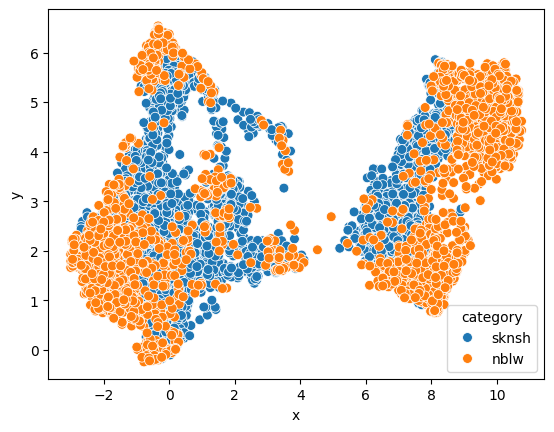

In [63]:

# Put into a DataFrame
plot_df = pd.DataFrame({
    "x": embedding[:, 0],
    "y": embedding[:, 1],
    "category": dataset_labels
})

# Scatter plot with automatic coloring by category
sns.scatterplot(data=plot_df, x="x", y="y", hue="category", s=50)

plt.show()

## Save embeddings in AnnData
- 

In [35]:
adata_sknsh

AnnData object with n_obs × n_vars = 2774 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'total_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'gene_name', 'id_in_vocab'
    obsm: 'X_pca'
    varm: 'PCs'

In [42]:
np.ones(100)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [39]:
adata_sknsh.obsm['scgpt'] = sknsh_scgpt_embeddings

In [44]:
adata_nblw.obsm['scgpt'] = nblw_scgpt_embeddings

In [ ]:
#adata_sknsh.write_h5ad("210824_aumc00012sc_10k_scRNAseq_scGPT.h5ad")

... storing 'Phase' as categorical


In [ ]:
#adata_nblw.write_h5ad("210824_aumc00013sc_10k_scRNAseq_scGPT.h5ad")

... storing 'Phase' as categorical
